# Designing and optimizing a coupled line bandpass filter
Microwave filters serve as essential components in microwave and radio frequency communication systems. These critical building blocks help us exert control over the frequencies that are transmitted through a system. Implementing microwave filters can be achieved through various methods, for example, utilizing lumped elements, sections of transmission lines, or a combination of both.

In this notebook, we will guide you through the process of designing and validating a bandpass filter using multiple sections of coupled microstrip lines. This practical application example is based on design specifications from the study [Ragani Taoufik, N. Amar Touhami, and M. Agoutane, "Designing a Microstrip coupled line bandpass filter", International Journal of Engineering and Technology 2(4), 266-269 (2013)](https://doi.org/10.14419/ijet.v2i4.1173). The specifications outlined in the study are aimed at creating a bandpass filter centered at 6 GHz with a bandwidth of 2 GHz.

<img src="img/coupled_line_bandpass_filter.png" width="400" alt="Schematic of a coupled line bandpass filter">


To take it a step further, we will also demonstrate how to design an improved coupled line filter that is more closely centered at 6 GHz with an improved return loss. This will be achieved by leveraging the powerful `optimize` module from the widely-used `SciPy` package. By the end of this notebook, you will have a deeper understanding of how to use `Tidy3D` and the microwave plugin to design, simulate, and validate microwave networks.

In [1]:
# Tidy3d imports
import tidy3d as td

# Tidy3d plugin imports
import tidy3d.plugins.smatrix as smatrix
import tidy3d.plugins.microwave as mw

# External modules needed for this notebook
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# uncomment the following line to install scikit-rf if it's not installed in your environment already
# pip install scikit-rf
import skrf as rf  # For validation using circuit models of the filter
from scipy import (
    optimize as opt,
)  # Used to optimize microstrip parameters for the filter

# We set the logging level to "ERROR". Otherwise there are numerous warnings due to the proximity of the structure to PML boundaries.
td.config.logging_level = "ERROR"

## Filter Design and Microstrip Parameters

We start from the coupled line filter proposed by Taoufik *et al*. [1]. In [1], the filter is designed using the insertion loss method, which is described in [2]. Although a full explanation of the insertion loss method is out of the scope of this notebook, we summarize the main four steps below:

1. Filter specifications: The initial step in designing a filter using the insertion loss method involves defining the desired filter response and the type of filter to be used. This includes outlining the passband and stopband frequencies, the maximum allowable insertion loss in the passband, the minimum required attenuation in the stopband, and the specific filter type (such as Butterworth, Chebyshev, Elliptic, etc.) best suited for the application.
2. Low-pass prototype design: Next, the order of the filter, which is the number of reactive elements, is determined based on the specified requirements. The order of the filter is typically chosen to achieve the desired attenuation in the stopband.
3. Computation of prototype element values: In this step, the values for the prototype elements of the filter are computed based on the filter type and order. These calculations are done using mathematical formulas specific to the filter type. Alternatively, precomputed tables for standard filter types can be used to look up the prototype element values.
4. Implementation of elements: Finally, the computed prototype element values are implemented as physical elements in the filter. Depending on the design and frequency requirements, these elements can be realized as lumped elements (inductors and capacitors) or as sections of transmission lines. In the case of a coupled lined filter, the lumped element values are transformed into a list of coupled line sections with desired even and odd characteristic line impedances, see [2].

First, we will simulate the filter as designed and implemented in [1]. Later, we will optimize the filter implementation by finding better values for the widths, lengths, and gaps of each segment. The designed filter in [1] is made up of four segments with the parameters given below:

| Segment  | Width (mm) |  Length (mm) |  Gap (mm) |
| -------- | ---------- | ------------ | --------- |
| 1 | 1.4 | 6 | 0.2 |
| 2 | 2.4 | 6 | 0.2 |
| 3 | 2.4 | 6 | 0.2 |
| 4 | 1.4 | 6 | 0.2 |


Using the tabulated parameters from [1], a `Tidy3D` simulation is set up that uses the [TerminalComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html) to extract scattering parameters from this 2-port device.

In [2]:
# Frequency range of interest is 2-10 GHz
freq0 = 6e9
# A sample frequency that is within the stopband of the filter
freq_stopband = 3e9
freqs = np.linspace(2, 10, 101) * 1e9
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))
lda0 = td.C_0 / freq0  # Central wavelength

# Materials used in this simulation
PEC = td.PECMedium()
eps_sub = 4.3  # Substrate permittivity
sub_medium = td.Medium(permittivity=eps_sub)  # define substrate medium

mm = 1e3  # Scaling used for millimeters
# Large value to ensure structures extend outside simulation domain
inf_eff = 1000 * mm

# Geometry parameters common to all designs
h_sub = 1.56 * mm  # Substrate thickness
h_trace = 0.035 * mm  # Thickness of metal layers

# Microstrip parameters taken from [1]
strips_W = [1.4 * mm, 2.4 * mm, 2.4 * mm, 1.4 * mm]
strips_L = [6 * mm, 6 * mm, 6 * mm, 6 * mm]
strips_G = [0.2 * mm, 0.2 * mm, 0.2 * mm, 0.2 * mm]

# Numpy arrays of the microstrip dimensions
lengths = np.array(strips_L)
widths = np.array(strips_W)
gaps = np.array(strips_G)

To facilitate the creation of the coupled line filter geometry, we define two helper functions below that generate coupled microstrips given lists of their lengths, widths, and gaps.

In [3]:
# This helper function generates the starting positions of the coupled microstrip line segments
def get_coupled_line_geometry(lengths, widths, gaps):
    # Coupled lines are generated from upper left to lower right centered at the origin
    total_length = np.sum(lengths)
    # Compute the total width
    total_width = 0
    prev_width = 0
    # Coupled line segments are aligned differently depending on their relative widths
    for width, gap in zip(widths, gaps):
        total_width += width + gap
        if width > prev_width:
            total_width += width - prev_width
        prev_width = width

    # Compute the starting positions of each segment the left bound and the top bound
    xstarts = []
    ystarts = []

    prev_xstart = -total_length / 2
    prev_ystart = total_width / 2
    prev_length = 0
    prev_width = 0
    prev_gap = 0
    for length, width, gap in zip(lengths, widths, gaps):
        # Compute x position of the segment (left bound)
        xstarts.append(prev_xstart + prev_length)

        # Compute y position of the segment (top bound)
        ystart = prev_ystart - prev_width - prev_gap
        if width < prev_width:
            ystart += width - prev_width
        ystarts.append(ystart)

        prev_xstart = xstarts[-1]
        prev_ystart = ystarts[-1]
        prev_length = length
        prev_width = width
        prev_gap = gap

    return total_length, total_width, xstarts, ystarts


# Generate the tidy3d structures representing the coupled line segments
# using the previously computed positions
def generate_coupled_lines(lengths, widths, gaps, xstarts, ystarts):
    coupled_lines = []
    # Each segment is composed of two microstrips
    for length, width, gap, xstart, ystart in zip(
        lengths, widths, gaps, xstarts, ystarts
    ):
        coupled_lines.append(
            td.Structure(
                geometry=td.Box.from_bounds(
                    rmin=(xstart, ystart - width, 0),
                    rmax=(xstart + length, ystart, h_trace),
                ),
                medium=PEC,
            )
        )
        coupled_lines.append(
            td.Structure(
                geometry=td.Box.from_bounds(
                    rmin=(xstart, ystart - 2 * width - gap, 0),
                    rmax=(xstart + length, ystart - width - gap, h_trace),
                ),
                medium=PEC,
            )
        )
    return coupled_lines

Now we may easily create and view the structure.

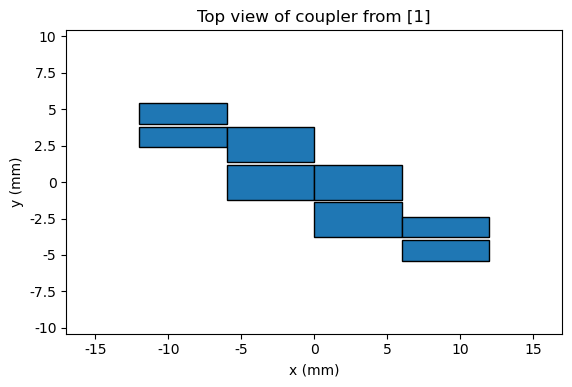

In [4]:
# Create the structures and geometry of the coupled line bandpass filter
(total_L, total_W, xstarts, ystarts) = get_coupled_line_geometry(lengths, widths, gaps)
coupled_lines = generate_coupled_lines(lengths, widths, gaps, xstarts, ystarts)
# Create the substrate block
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=sub_medium,
)
# Define the simulation domain size with some extra padding based on central wavelength
Lx = total_L + lda0 / 5
Ly = total_W + lda0 / 5
Lz = h_sub + lda0 / 8

# View the created line coupler
fig, ax = plt.subplots()
for geo in coupled_lines:
    geo.plot(z=0, ax=ax)
# Formatter to help plotting in units of millimeters
formatter = ticker.FuncFormatter(lambda y, _: "{:g}".format((1e-3) * y))
xlbl = "x (mm)"
ylbl = "y (mm)"
# Update plot labels
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel(xlbl)
ax.set_ylabel(ylbl)
ax.set_xlim(-Lx / 2, Lx / 2)
ax.set_ylim(-Ly / 2, Ly / 2)
ax.set_title("Top view of coupler from [1]")
plt.show()

With the structure created, we now set up the `Tidy3D` Simulation that will be used by the [TerminalComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html).

First, we define mesh override structures so that the small height of the microstrips is captured accurately. In addition, we ensure that there are plenty of cells along the width and length of the structure where the fields will be strongly confined.

In [5]:
# Definition of mesh overrides
mesh_overrides = [
    # The first mesh override ensures the small height of the strips is accurately modeled.
    td.MeshOverrideStructure(
        geometry=td.Box(
            center=[0, 0, h_trace / 2],
            size=[1.1 * total_L, 1.1 * total_W, h_trace],
        ),
        dl=[total_L / 200, np.min(widths) / 20, h_trace],
    ),
    # The second mesh override refined the grid within the substrate.
    td.MeshOverrideStructure(
        geometry=td.Box(
            center=[0, 0, -h_sub / 2],
            size=[1.1 * total_L, 1.1 * total_W, h_sub],
        ),
        dl=[total_L / 200, np.min(widths) / 20, h_sub / 20],
    ),
]

Now, the rest of the components are set up for the `Tidy3D` simulation. Note the use of a PEC boundary condition for the minus *z* axis, which simplifies the modeling of the microstrips' ground plane.

In [6]:
# Field monitor to view the electromagnetic fields along the propagation direction.
field_monitor = td.FieldMonitor(
    center=(0, 0, -h_sub / 2),
    size=(td.inf, td.inf, 0),
    freqs=[freq_stopband, freq0],
    name="field",
)
# Boundary conditions are perfectly matched layers, except for the minus z boundary.
boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary(minus=td.PECBoundary(), plus=td.PML()),
)
# The base tidy3D Simulation ready to be used by the TerminalComponentModeler
sim = td.Simulation(
    center=(0, 0, Lz / 2 - h_sub),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=40.0,
        wavelength=lda0,
        dl_min=h_trace / 5,
        override_structures=mesh_overrides,
    ),
    structures=[substrate] + coupled_lines,
    sources=[],
    monitors=[field_monitor],
    run_time=10e-9,
    boundary_spec=boundary_spec,
)

## Setting up the TerminalComponentModeler
Lumped ports are now added at the left and right sides of the filter. The lumped ports are used in the [TerminalComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html) to set up simulations for extracting the scattering parameters of the network. Each port represents an additional simulation that needs to be run in order to extract the full scattering matrix of the system.

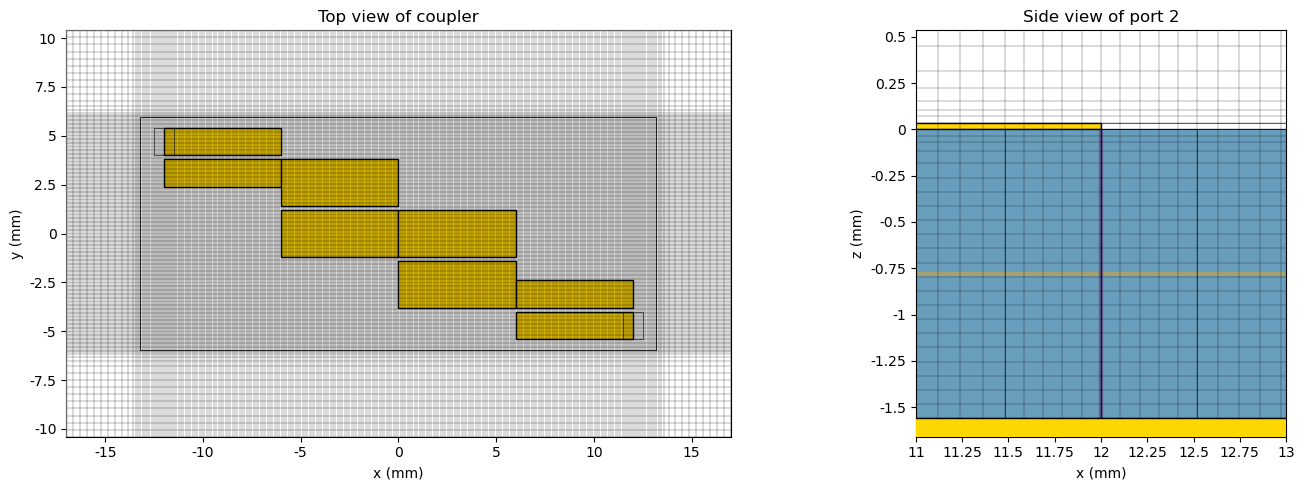

In [7]:
# Compute port xy locations
port_left = (xstarts[0], ystarts[0] - widths[0] / 2)
port_right = (xstarts[-1] + lengths[-1], ystarts[-1] - gaps[-1] - 1.5 * widths[-1])
# Impedance at each port
reference_impedance = 50
port_1_td = smatrix.LumpedPort(
    center=(port_left[0], port_left[1], -h_sub / 2),
    size=(0, widths[0], h_sub),
    voltage_axis=2,
    name="lumped_port_1",
    impedance=reference_impedance,
)

port_2_td = smatrix.LumpedPort(
    center=(port_right[0], port_right[1], -h_sub / 2),
    size=(0, widths[-1], h_sub),
    voltage_axis=2,
    name="lumped_port_2",
    impedance=reference_impedance,
)

modeler = smatrix.TerminalComponentModeler(
    simulation=sim,
    ports=[port_1_td, port_2_td],
    freqs=freqs,
    verbose=True,
)

# Before running the simulations, we can view the mesh to get an idea of how the mesh overrides have performed.
# The simulation objects created within the terminal component modeler will take port mesh refinement into account.
sim_port1 = list(modeler.sim_dict.values())[0]

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 5))
hlim = [-Lx / 2, Lx / 2]
vlim = [-Ly / 2, Ly / 2]
ax = sim_port1.plot(z=h_trace / 2, ax=ax1)
sim_port1.plot_grid(z=h_trace / 2, ax=ax1, hlim=hlim, vlim=vlim)
# Update plot labels
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel(xlbl)
ax.set_ylabel(ylbl)
ax.set_title("Top view of coupler")

hlim = [port_2_td.bounds[0][0] - 1 * mm, port_2_td.bounds[1][0] + 1 * mm]
vlim = [sim.bounds[0][2] - 100, h_trace + 500]
ax = sim_port1.plot(y=port_2_td.center[1], ax=ax2)
sim_port1.plot_grid(y=h_trace / 2, ax=ax, hlim=hlim, vlim=vlim)
# Update plot labels
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel(xlbl)
ax.set_ylabel("z (mm)")
ax.set_title("Side view of port 2")
plt.show()

In [8]:
# Run the jobs and save the scattering parameters
s_matrix = modeler.run()

14:10:12 EDT Created task 'smatrix_lumped_port_1' with task_id                  
             'fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=867532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=114878;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241\taskId]8;;\]8;id=867532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241\=]8;;\]8;id=163206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241\fdve]8;;\]8;id=867532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241\-35a1065f-81f]8;;\
             ]8;id=867532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241\b-48e4-8c78-3deb47a2e241']8;;\.

Output()

14:10:13 EDT Created task 'smatrix_lumped_port_2' with task_id                  
             'fdve-b58f8e87-5ab5-432d-a37f-4fe136ed6f80' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=678450;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b58f8e87-5ab5-432d-a37f-4fe136ed6f80\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=562417;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b58f8e87-5ab5-432d-a37f-4fe136ed6f80\taskId]8;;\]8;id=678450;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b58f8e87-5ab5-432d-a37f-4fe136ed6f80\=]8;;\]8;id=76995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b58f8e87-5ab5-432d-a37f-4fe136ed6f80\fdve]8;;\]8;id=678450;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b58f8e87-5ab5-432d-a37f-4fe136ed6f80\-b58f8e87-5ab]8;;\
             ]8;id=678450;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b58f8e87-5ab5-432d-a37f-4fe136ed6f80\5-432d-a37f-4fe136ed6f80']8;;\.

Output()

14:10:20 EDT Started working on Batch.

14:10:22 EDT Maximum FlexCredit cost: 0.207 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:11:21 EDT Batch complete.

Output()

14:11:23 EDT loading simulation from                                            
             ./fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241.hdf5

Output()

14:11:24 EDT loading simulation from                                            
             ./fdve-b58f8e87-5ab5-432d-a37f-4fe136ed6f80.hdf5

## Plotting Fields

The frequency-domain fields have been recorded over the extent of the coupled line filter between the ground plane and microstrips. Although not needed for extracting scattering parameters, the plots below demonstrate the effect of the filter on frequencies within and frequencies outside the passband. In these plots, the excited port is located in the upper left of the figure, and the transmission port is located at the bottom right.

14:11:25 EDT loading simulation from                                            
             ./fdve-35a1065f-81fb-48e4-8c78-3deb47a2e241.hdf5

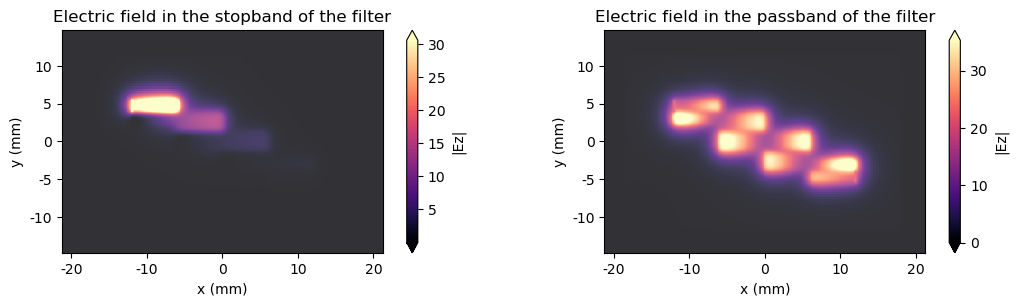

In [9]:
sim1 = modeler.batch.load()["smatrix_lumped_port_1"]

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11, 3))
sim1.plot_field(field_monitor_name="field", field_name="Ez", val="abs", f=freq_stopband, ax=ax1)
# Update plot labels
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xlabel(xlbl)
ax1.set_ylabel(ylbl)
ax1.set_title("Electric field in the stopband of the filter")
sim1.plot_field(field_monitor_name="field", field_name="Ez", val="abs", f=freq0, ax=ax2)
# Update plot labels
ax2.xaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax2.set_xlabel(xlbl)
ax2.set_ylabel(ylbl)
ax2.set_title("Electric field in the passband of the filter")
plt.show()

## Creating a Network Using the `scikit-rf` Package
In order to help us validate the design, we use the open source `scikit-rf` package. By treating each coupled line segment as an independent transmission line [2], we can build a simple circuit model of the network by chaining the four segments using the ABCD matrix representation [2].

Once ABCD matrices have been generated for each segment, it is quite simple to compute the scattering parameters using the functionality provided by `scikit-rf`.

In [10]:
# Helper function that creates a model of the 2 port filter network using the scikit-rf package.
# This model is useful for validation, but it is based on transmission line models.
# As a result, it will not be as accurate as a converged full-wave solution.
def create_network_model_four_segment_coupler_with_scikit(
    freqs, lengths, widths, height, gaps, eps_sub
):
    # Helper function that creates an ABCD matrix for each coupler section.
    def abcd_from_coupled_strip(lambda_0, length, width, height, gap, eps_sub):
        # Use models provided in the microwave plugin to estimate characteristic impedance
        # and effective permittivities for the even and odd modes of the coupled line
        (z0_even, z0_odd, er_eff_even, er_eff_odd) = (
            mw.models.coupled_microstrip.compute_line_params(
                relative_permittivity=eps_sub, width=width, height=height, gap=gap
            )
        )
        # First we estimate the electrical length of the segment
        # Use the geometric mean of the even/odd permittivities as an approximation for the relative permittivity
        er_geo_mean = np.sqrt(er_eff_even * er_eff_odd)
        # Phase constant is computed using free space wavelength and the effective permittivity
        beta = 2 * np.pi / lambda_0 * np.sqrt(er_geo_mean)
        # Microstrips terminated by an open circuit have fringing fields that can be modeled as a slight extension to the microstrip.
        # This functionality is available in the microwave plugin.
        dL = mw.models.microstrip.compute_end_effect_length(eps_sub, er_geo_mean, width, height)
        # With the modified length and phase constant the electrical length is estimated for this segment.
        theta = beta * (length + dL)
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        # Compute the characteristic impedance of the coupler line segment using Table 8.8 from [2]
        impedance = np.sqrt(
            ((z0_even - z0_odd) ** 2 - (z0_even + z0_odd) ** 2 * costheta**2).astype(complex)
        ) / (2 * sintheta)
        # Using Equation 8.103 from [2]
        cosbetal = costheta * (z0_even + z0_odd) / (z0_even - z0_odd)
        sinthetal = np.sqrt((1 - cosbetal**2).astype(complex))
        # This is the canonical ABCD matrix for a transmission line
        A = cosbetal
        B = 1j * impedance * sinthetal
        C = 1j / impedance * sinthetal
        D = cosbetal
        # Change location of frequency dimension to conform to the scikit-rf format
        abcd = np.array([[A, B], [C, D]])
        return np.transpose(abcd, axes=(2, 0, 1))

    # Compute the wavelengths in free space
    lambda_0 = 3e14 / freqs  # speed of light in microns/s
    abcd1 = abcd_from_coupled_strip(
        lambda_0,
        length=lengths[0],
        width=widths[0],
        height=height,
        gap=gaps[0],
        eps_sub=eps_sub,
    )
    abcd2 = abcd_from_coupled_strip(
        lambda_0,
        length=lengths[1],
        width=widths[1],
        height=height,
        gap=gaps[1],
        eps_sub=eps_sub,
    )

    freq = rf.Frequency.from_f(freqs, unit="Hz")
    abcd1_ntw = rf.Network(frequency=freq, a=abcd1, name="cstrip1")
    abcd2_ntw = rf.Network(frequency=freq, a=abcd2, name="cstrip2")

    port1 = rf.Circuit.Port(freq, "port1")
    port2 = rf.Circuit.Port(freq, "port2")

    # The complete network is made up of four segments where there are only two unique segments
    chain = abcd1_ntw**abcd2_ntw**abcd2_ntw**abcd1_ntw

    # Add the ports to the network
    cnx = [
        [(port1, 0), (chain, 0)],
        [(chain, 1), (port2, 0)],
    ]
    # building the circuit
    cir = rf.Circuit(cnx)
    # return the resulting Network from the 'network' parameter:
    return cir.network

## Plotting the Scattering Parameters from the Initial Design

We may now plot the computed scattering parameters $S_{11}$ and $S_{12}$ using both the results from the `scikit-rf` model and the `Tidy3D` simulations.

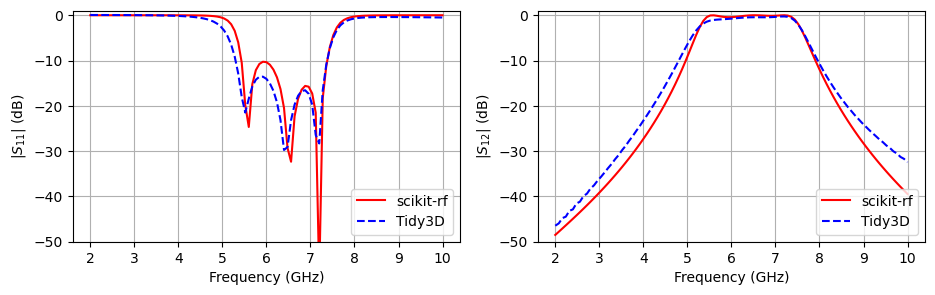

In [11]:
# Create the network using transmission line models for comparison with tidy3D simulations
ntw = create_network_model_four_segment_coupler_with_scikit(
    freqs=freqs,
    lengths=lengths,
    widths=widths,
    height=h_sub,
    gaps=gaps,
    eps_sub=eps_sub,
)
# Plot the scattering parameters related to reflection and transmission
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))
ax1.plot(
    freqs / 1e9,
    20 * np.log10(np.abs(ntw.s[:, 0, 0])),
    "-r",
    s_matrix.f / 1e9,
    20 * np.log10(np.abs(s_matrix.isel(port_out=0, port_in=0).values.flatten())),
    "--b",
)
ax1.legend(["scikit-rf", "Tidy3D"], loc="lower right")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel(r"$|S_{11}|$ (dB)")
ax1.set_ylim([-50, 1])
ax1.grid()

ax2.plot(
    freqs / 1e9,
    20 * np.log10(np.abs(ntw.s[:, 0, 1])),
    "-r",
    s_matrix.f / 1e9,
    20 * np.log10(np.abs(s_matrix.isel(port_out=0, port_in=1).values.flatten())),
    "--b",
)
ax2.legend(["scikit-rf", "Tidy3D"], loc="lower right")
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel(r"$|S_{12}|$ (dB)")
ax2.set_ylim([-50, 1])
ax2.grid()
plt.show()

## Optimized Design of Bandpass Filter

From the previous results we observe that the filter is not exactly centered at 6 GHz, which was a desired feature. In this part, we optimize the microstrip parameters from [1] to achieve a better implementation of the desired filter.

The specified even and odd characteristic impedances for the coupled lines from [1] are tabulated below.

| Segment  | $$Z_{\textrm{even}} ~(\Omega)$$ | $$Z_{\textrm{odd}} ~(\Omega)$$ |
| -------- | ---------- | ------------ |
| 1 |   101.5 | 38.5 |
| 2 |   71 | 39 |
| 3 |   71 | 39 |
| 4 |   101.5 | 38.5 |

In the `microwave` plugin, we have made available approximate models for a few common transmission line types. These models allow us to quickly compute the expected even and odd characteristic impedances for a segment of coupled microstrip lines with a given width and gap.

We now use the `optimize` module from the `scipy` package to find better widths, gaps, and lengths. These optimized parameters will result in coupled microstrip lines that more closely match the desired even and odd characteristic impedances from [1].

In [12]:
# Given parameters are a list of desired even and odd impedances, from [1]
Z_evens = [101.5, 71, 71, 101.5]
Z_odds = [38.5, 39, 39, 38.5]


# Define a target function that is used to find the optimal width and gap of a coupled microstrip given a desired even/odd impedance pair
def target_func(x, *args):
    width = x[0]
    gap = x[1]
    # Tidy3D microwave plugin function to quickly approximate parameters of coupled microstrips
    (z0_even, z0_odd, _, _) = mw.models.coupled_microstrip.compute_line_params(
        relative_permittivity=eps_sub, width=width, height=h_sub, gap=gap
    )
    even_target = args[0]
    odd_target = args[1]
    # Simple error metric
    error = (z0_even - even_target) ** 2 + (z0_odd - odd_target) ** 2
    return error


# Use approximate models for microstrip parameters to compute the needed widths, gaps, and lengths of segments
strips_W = []
strips_G = []
strips_L = []
for Z_even, Z_odd in zip(Z_evens, Z_odds):
    # Search for solutions within the domain 1 < width < 10 and 0.05 < gap < 1
    bounds = [(1 * mm, 10 * mm), (0.05 * mm, 1 * mm)]
    # Target values for even/odd impedances
    args = (Z_even, Z_odd)
    res = opt.minimize(
        target_func,
        x0=[5 * mm, 0.5 * mm],
        bounds=bounds,
        tol=1e-4,
        # We use one of the suggested algorithms from SciPy for bound constrained optimization problems.
        method="L-BFGS-B",
        args=args,
    )
    width = res.x[0]
    gap = res.x[1]
    strips_W.append(width)
    strips_G.append(gap)
    # Compute the required segment length which needs to have an electrical length of lambda/4
    (_, _, er_eff_even, er_eff_odd) = mw.models.coupled_microstrip.compute_line_params(
        relative_permittivity=eps_sub, width=width, height=h_sub, gap=gap
    )
    # Use the geometric mean of the even/odd permittivities as an approximation for the relative permittivity
    er_geo_mean = np.sqrt(er_eff_even * er_eff_odd)
    length = (lda0) / 4 / (np.sqrt(er_geo_mean))
    # Microstrips terminated by an open circuit have fringing fields that can be modelled as a slight extension to the microstrip
    dL = mw.models.microstrip.compute_end_effect_length(
        eps_sub, er_geo_mean, width, h_sub
    )
    # As a result, we need a slightly shorter section
    length -= dL
    strips_L.append(length)

# Numpy arrays of the microstrip dimensions
lengths = np.array(strips_L)
widths = np.array(strips_W)
gaps = np.array(strips_G)

print("The new optimized dimensions for the coupled microstrips are: ")
print(f"Widths (mm): {widths*1e-3}")
print(f"Lengths (mm): {lengths*1e-3}")
print(f"Gaps (mm): {gaps*1e-3}")

The new optimized dimensions for the coupled microstrips are: 
Widths (mm): [1.4161279  2.39856517 2.39856517 1.4161279 ]
Lengths (mm): [6.60907322 6.39916412 6.39916412 6.60907322]
Gaps (mm): [0.13409214 0.3863375  0.3863375  0.13409214]


Using the previously defined helper functions, we can quickly set up the new structures and simulations.

In [13]:
# Create the structures and geometry of the coupled line bandpass filter
(total_L, total_W, xstarts, ystarts) = get_coupled_line_geometry(lengths, widths, gaps)
coupled_lines = generate_coupled_lines(lengths, widths, gaps, xstarts, ystarts)

# Define the simulation domain size with some extra padding based on central wavelength
Lx = total_L + lda0 / 5
Ly = total_W + lda0 / 5
Lz = h_sub + lda0 / 8

# Definition of mesh overrides
mesh_overrides = [
    # The first mesh override ensures the small height of the strips is accurately modeled.
    td.MeshOverrideStructure(
        geometry=td.Box(
            center=[0, 0, h_trace / 2],
            size=[1.1 * total_L, 1.1 * total_W, h_trace],
        ),
        dl=[total_L / 200, np.min(widths) / 20, h_trace],
    ),
    # The second mesh override refined the grid within the substrate.
    td.MeshOverrideStructure(
        geometry=td.Box(
            center=[0, 0, -h_sub / 2],
            size=[1.1 * total_L, 1.1 * total_W, h_sub],
        ),
        dl=[total_L / 200, np.min(widths) / 20, h_sub / 20],
    ),
]

# The base tidy3D Simulation ready to be used by the TerminalComponentModeler
sim = td.Simulation(
    center=(0, 0, Lz / 2 - h_sub),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=40.0,
        wavelength=lda0,
        dl_min=h_trace / 5,
        override_structures=mesh_overrides,
    ),
    structures=[substrate] + coupled_lines,
    sources=[],
    monitors=[field_monitor],
    run_time=10e-9,
    boundary_spec=boundary_spec,
)

# Compute port xy locations
port_left = (xstarts[0], ystarts[0] - widths[0] / 2)
port_right = (xstarts[-1] + lengths[-1], ystarts[-1] - gaps[-1] - 1.5 * widths[-1])
# Impedance at each port
reference_impedance = 50
port_1_td = smatrix.LumpedPort(
    center=(port_left[0], port_left[1], -h_sub / 2),
    size=(0, widths[0], h_sub),
    voltage_axis=2,
    name="lumped_port_1",
    impedance=reference_impedance,
)

port_2_td = smatrix.LumpedPort(
    center=(port_right[0], port_right[1], -h_sub / 2),
    size=(0, widths[-1], h_sub),
    voltage_axis=2,
    name="lumped_port_2",
    impedance=reference_impedance,
)

modeler = smatrix.TerminalComponentModeler(
    simulation=sim,
    ports=[port_1_td, port_2_td],
    freqs=freqs,
    verbose=True,
)

# Run the jobs and save the scattering parameters
s_matrix = modeler.run()

14:11:26 EDT Created task 'smatrix_lumped_port_1' with task_id                  
             'fdve-c2d09797-c68c-4ded-95c8-967b5a0b206e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=245085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c2d09797-c68c-4ded-95c8-967b5a0b206e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=270313;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c2d09797-c68c-4ded-95c8-967b5a0b206e\taskId]8;;\]8;id=245085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c2d09797-c68c-4ded-95c8-967b5a0b206e\=]8;;\]8;id=68075;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c2d09797-c68c-4ded-95c8-967b5a0b206e\fdve]8;;\]8;id=245085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c2d09797-c68c-4ded-95c8-967b5a0b206e\-c2d09797-c68]8;;\
             ]8;id=245085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c2d09797-c68c-4ded-95c8-967b5a0b206e\c-4ded-95c8-967b5a0b206e']8;;\.

Output()

14:11:27 EDT Created task 'smatrix_lumped_port_2' with task_id                  
             'fdve-89fb21d0-4f37-4249-979f-03f9e14688ec' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=183883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89fb21d0-4f37-4249-979f-03f9e14688ec\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=878868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89fb21d0-4f37-4249-979f-03f9e14688ec\taskId]8;;\]8;id=183883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89fb21d0-4f37-4249-979f-03f9e14688ec\=]8;;\]8;id=385453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89fb21d0-4f37-4249-979f-03f9e14688ec\fdve]8;;\]8;id=183883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89fb21d0-4f37-4249-979f-03f9e14688ec\-89fb21d0-4f3]8;;\
             ]8;id=183883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-89fb21d0-4f37-4249-979f-03f9e14688ec\7-4249-979f-03f9e14688ec']8;;\.

Output()

14:11:29 EDT Started working on Batch.

14:11:30 EDT Maximum FlexCredit cost: 0.205 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

14:12:29 EDT Batch complete.

Output()

14:12:31 EDT loading simulation from                                            
             ./fdve-c2d09797-c68c-4ded-95c8-967b5a0b206e.hdf5

Output()

14:12:36 EDT loading simulation from                                            
             ./fdve-89fb21d0-4f37-4249-979f-03f9e14688ec.hdf5

### Plotting the Scattering Parameters from the Optimized Design

We again create a transmission line model of the network using `scikit-rf` and the helper function `create_network_model_four_segment_coupler_with_scikit`. We plot the scattering parameters for the optimized design and compare to those computed by the `scikit-rf` model.

The optimized filter is now centered at 6 GHz. In addition, the return loss has increased from about 15 dB to approximately 30 dB around the central frequency, which indicates much less reflected power.

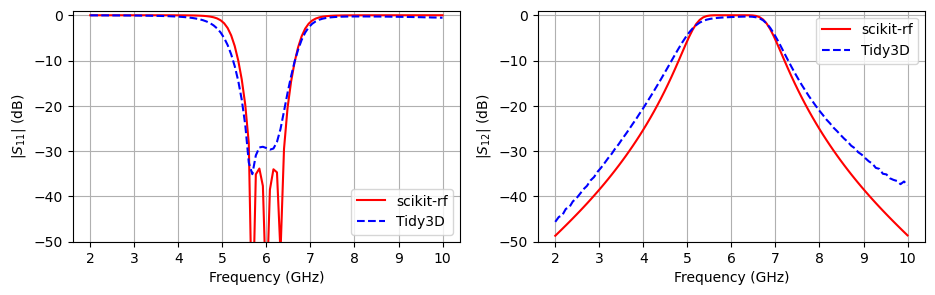

In [14]:
# Create the network using transmission line models for comparison with tidy3D simulations
ntw = create_network_model_four_segment_coupler_with_scikit(
    freqs=freqs,
    lengths=lengths,
    widths=widths,
    height=h_sub,
    gaps=gaps,
    eps_sub=eps_sub,
)

# Plot the scattering parameters related to reflection and transmission
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))
ax1.plot(
    freqs / 1e9,
    20 * np.log10(np.abs(ntw.s[:, 0, 0])),
    "-r",
    s_matrix.f / 1e9,
    20 * np.log10(np.abs(s_matrix.isel(port_out=0, port_in=0).values.flatten())),
    "--b",
)
ax1.legend(["scikit-rf", "Tidy3D"], loc="lower right")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel(r"$|S_{11}|$ (dB)")
ax1.set_ylim([-50, 1])
ax1.grid()

ax2.plot(
    freqs / 1e9,
    20 * np.log10(np.abs(ntw.s[:, 0, 1])),
    "-r",
    s_matrix.f / 1e9,
    20 * np.log10(np.abs(s_matrix.isel(port_out=0, port_in=1).values.flatten())),
    "--b",
)
ax2.legend(["scikit-rf", "Tidy3D"], loc="upper right")
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel(r"$|S_{12}|$ (dB)")
ax2.set_ylim([-50, 1])
ax2.grid()
plt.show()

## References

[1]   Taoufik, Ragani, N. Amar Touhami, and M. Agoutane. "Designing a Microstrip coupled line bandpass filter."
      International Journal of Engineering & Technology 2, no. 4 (2013): 266.

[2]   David M. Pozar, "Microwave Filters" in Microwave Engineering, 4th ed. 2011, ch. 8.